# Opening a Clothing Store in New York City

In [1]:
import numpy as np # library to handle data in a vectorized manner
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

In [2]:
def get_new_york_data():
    
    #Collect New York City data
    
    NY_DATASET = "https://cocl.us/new_york_dataset"
    resp = requests.get(NY_DATASET).json()
    features = resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
    new_york_data = pd.DataFrame(columns=column_names)

    for data in features:
        borough = data['properties']['borough']
        neighborhood_name = data['properties']['name']

        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]

        new_york_data = new_york_data.append({'Borough': borough,
                                              'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)

    return new_york_data

In [5]:
nydata=get_new_york_data()

In [6]:
nydata.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
from bs4 import BeautifulSoup
#import BeautifulSoup to read wikipedia page

In [17]:
def get_population_per_neighborhood(read_from_csv=False):
    
    #BeautifulSoup function, to go on wikipedia and obtain population per borough/neighborhood
    
    if not read_from_csv:
        WIKI_LINK = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"
        ROOT_WIKI_LINK = "https://en.wikipedia.org"
        page = requests.get(WIKI_LINK)
        soup = BeautifulSoup(page.text, 'html.parser')
        population_list = []
        for table_row in soup.select("table.wikitable tr"):
            cells = table_row.findAll('td')
            if len(cells) > 0:
                borough = cells[0].text.strip().replace(
                    '\xa0', ' ').split(' ')[0]
                population = int(cells[3].text.strip().replace(',', ''))
                for item in cells[4].findAll('a'):
                    neighborhood = item.text
                    neighbourhood_page = requests.get(
                        ROOT_WIKI_LINK+item['href'])
                    soup = BeautifulSoup(
                        neighbourhood_page.text, 'html.parser')
                    table = soup.select("table.infobox tr")
                    should_record = False
                    for row in table:
                        head = row.find('th')
                        body = row.find('td')
                        if head and 'population' in head.text.lower():
                            should_record = True
                            continue
                        if should_record:
                            try:
                                population_list.append(
                                    [borough, neighborhood, int(body.text.replace(',', ''))])
                            except:
                                pass
                            should_record = False
        df = pd.DataFrame(population_list, columns=[
                          "Borough", "Neighborhood", "Population"])
        df.to_csv('population.csv')
    else:
        df = pd.read_csv('population.csv')
    df = df.sort_values(by=['Borough'])
    df = df.drop_duplicates(subset='Neighborhood', keep='last')
    return df

In [18]:
nycpop = get_population_per_neighborhood()

In [19]:
nycpop.head()

,Borough,Neighborhood,Population
0,Bronx,Melrose,24913
25,Bronx,Bruckner,38557
26,Bronx,Castle Hill,38557
27,Bronx,Clason Point,9136
28,Bronx,Harding Park,9136


Text(0.5, 1.0, 'Population per Borough')

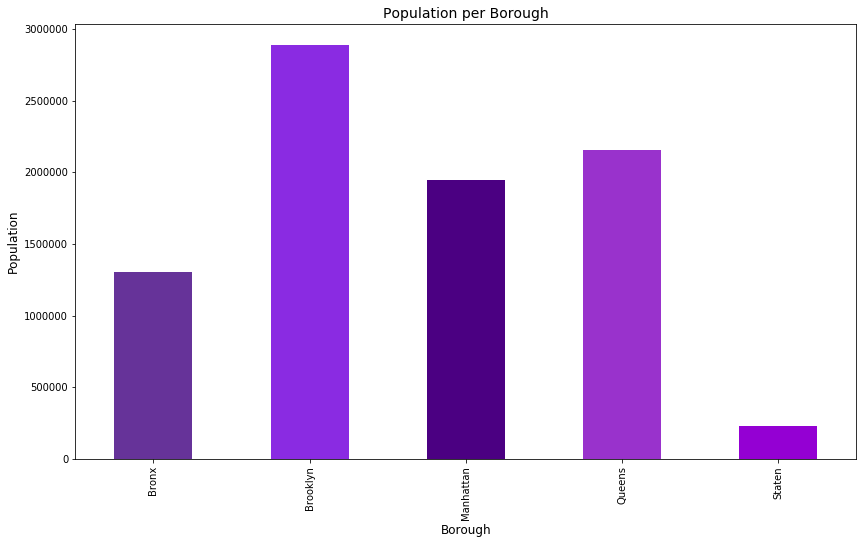

In [28]:
#some graphs to show what we're talking about
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

nycpop.groupby('Borough').Population.sum().plot(kind='bar',figsize = (14, 8),color=['rebeccapurple','blueviolet','indigo','darkorchid','darkviolet'])

plt.ylabel('Population', fontsize=12)
plt.xticks(fontsize=10)
plt.xlabel('Borough', fontsize=12)
plt.title('Population per Borough', fontsize = 14)

In [43]:
# Get information for Retail Stores
def get_data(lat, lng, borough, neighborhood):

    radius = 1000
    LIMIT = 100
    VERSION = '20180605'
    FS_CLIENT_ID = "X5STHTOJ5ALK42QMTYDXRXWTKQ20FB4OOWKA5IQZ4PE1D5ZI"
    FS_CLIENT_SECRET = "VPEBQYOI35SAJ5EOP5L34DXJTRQIKHNT5ERK051GFSSQKNWU"
#https://developer.foursquare.com/docs/build-with-foursquare/categories/
    FS_CLOTHING_KEY = "4bf58dd8d48988d103951735"
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        FS_CLIENT_ID,
        FS_CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT,
        FS_CLOTHING_KEY)
    response = requests.get(url)
    if not response.status_code == 200:
        print("ERROR", response.status_code, response.content)
        return None
    results = response.json()
    venue_data = results["response"]["venues"]
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['id']
            venue_name = row['name']
            lat = row["location"]["lat"]
            lng = row["location"]["lng"]
            venue_details.append(
                [venue_id, venue_name, lat, lng, borough, neighborhood])
        except KeyError:
            pass

    column_names = ['Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    df = pd.DataFrame(venue_details, columns=column_names)
    return df

In [46]:
# Let us also write another function to utilize the nyc_df to get hospital data
def get_clothing_stores(df):

    column_names = ['Name', 'Latitude',
                    'Longitude', "Borough", "Neighborhood"]
    data = []
    for i, row in df.iterrows():
        h_df = get_data(
            row["Latitude"], row["Longitude"], row["Borough"], row["Neighborhood"])
        if h_df is not None:
            for x, hrow in h_df.iterrows():
                data.append([hrow[column] for column in column_names])

    n_df = pd.DataFrame(data, columns=column_names)
    n_df.to_csv('clothing_stores_nyc.csv')
    return n_df

In [47]:
# Now let us use the above function
nyc = get_clothing_stores(nydata)
nyc.head()

,Name,Latitude,Longitude,Borough,Neighborhood
0,Rainbow Shops,40.898166,-73.855052,Bronx,Wakefield
1,Blinking Genii,40.896970,-73.855026,Bronx,Wakefield
2,Jerseyman Cap USA,40.898116,-73.854388,Bronx,Wakefield
3,B&R Uniforms,40.891888,-73.858560,Bronx,Wakefield
4,Jimmy Jazz,40.873286,-73.824370,Bronx,Co-op City


In [59]:
# now we will group by neighborhood to see how many stores there are in each location
nyc2=nyc.groupby('Borough').count()
nyc2.head()

,Name,Latitude,Longitude,Neighborhood
Borough,,,,
Bronx,922,922,922,922
Brooklyn,2137,2137,2137,2137
Manhattan,1856,1856,1856,1856
Queens,1021,1021,1021,1021
Staten Island,350,350,350,350


In [144]:
nyc3 = nyc2.sort_values(by= ['Name'], ascending = False)
nyc4 = nyc3.rename(columns={'Name': 'Number of Clothing Stores'})

nyc4.drop(columns = 'Latitude',inplace = True)
nyc4.drop(columns = 'Longitude',inplace = True)
nyc4.drop(columns = 'Neighborhood',inplace = True)

nyc4.head()


,Number of Clothing Stores
Borough,
Brooklyn,2137
Manhattan,1856
Queens,1021
Bronx,922
Staten Island,350


Text(0.5, 1.0, 'Stores per Borough')

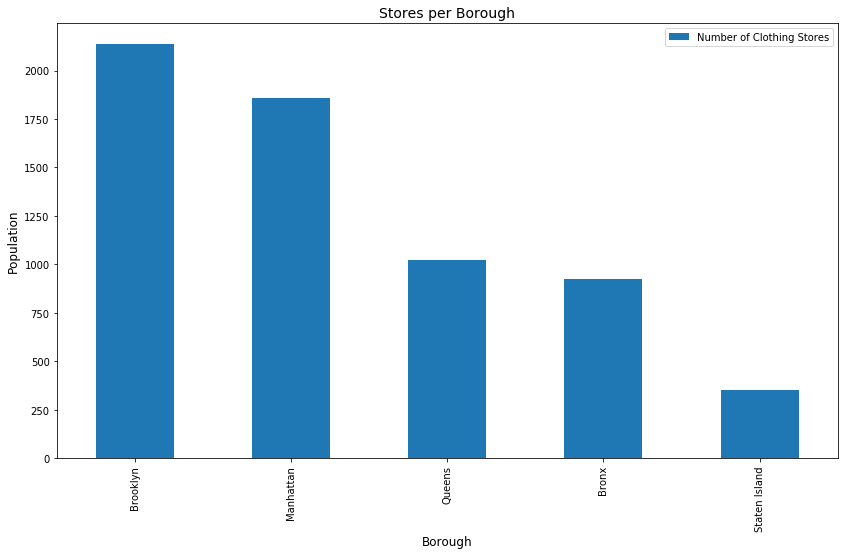

In [189]:
#a graph to see what the data looks like
nyc4.plot(kind='bar',figsize = (14, 8))
plt.ylabel('Population', fontsize=12)
plt.xticks(fontsize=10)
plt.xlabel('Borough', fontsize=12)
plt.title('Stores per Borough', fontsize = 14)

In [148]:
#merge dataset, population and number of retail stores
df = pd.merge(nyc, nycpop, how="inner", on=["Borough"])
df.head()

,Name,Latitude,Longitude,Borough,Neighborhood_x,Neighborhood_y,Population
0,Rainbow Shops,40.898166,-73.855052,Bronx,Wakefield,Melrose,24913
1,Rainbow Shops,40.898166,-73.855052,Bronx,Wakefield,Bruckner,38557
2,Rainbow Shops,40.898166,-73.855052,Bronx,Wakefield,Castle Hill,38557
3,Rainbow Shops,40.898166,-73.855052,Bronx,Wakefield,Clason Point,9136
4,Rainbow Shops,40.898166,-73.855052,Bronx,Wakefield,Harding Park,9136


In [149]:
df.dtypes

Name               object
Latitude          float64
Longitude         float64
Borough            object
Neighborhood_x     object
Neighborhood_y     object
Population          int64
dtype: object

In [153]:
df2 = df.groupby(['Borough','Name','Latitude','Longitude']).sum()
df3 = df2.sort_values(by= ['Name'], ascending = False)
df3

Population
Borough   Name                                               Latitude  Longitude             
Brooklyn  ÅLAND                                              40.718736 -73.960746     5779164
          zuzu boutique                                      40.603726 -73.996326     5779164
Bronx     zumiez                                             40.863788 -73.827625     3917160
Brooklyn  yourstrulybrand                                    40.696117 -73.933182     5779164
          your shoo                                          40.627293 -73.980532     2889582
          yole                                               40.640990 -73.948344    11558328
Queens    xios                                               40.704433 -73.797681     6473811
Manhattan xclusive arrivals                                  40.792928 -73.940424     1947540
Brooklyn  vintage Brooklyn Mobile Boutique                   40.719129 -73.940268     2889582
Manhattan victoria fashion                                   40.797462 -73.939389     1947540
Queens    vibes mens clothing                                40.707601 -73.795791     4315874
Brooklyn  value depot                                        40.578383 -73.953125     8668746
Bronx     urban style                                        40.824459 -73.889465     3917160
Brooklyn  undercover waterwear                               40.616333 -73.968446     5779164
          tumbleweed                                         40.685234 -73.944019     2889582
          top this hat                                       40.617920 -73.957649    11558328
          top gun                                            40.669220 -73.985931     2889582
Bronx     three floors Dept Store                            40.862156 -73.894417     1305720
          third ave                                          40.821072 -73.912500     3917160
Manhattan the westside                                       40.718540 -74.010295     3895080
Queens    the swellife                                       40.586582 -73.815187     4315874
          the notion                                         40.585381 -73.817154     4315874
Brooklyn  the lyfe shop                                      40.686457 -73.923275     2889582
Manhattan the heights sports wear                            40.848701 -73.934127     1947540
Brooklyn  the co-op nyc                                      40.651230 -73.944122     8668746
Bronx     the childrens place                                40.881752 -73.882803     1305720
Brooklyn  the children's place                               40.669770 -73.908675     8668746
          the booth nyc                                      40.642811 -74.009712     2889582
Queens    telco ridgewood                                    40.706045 -73.881023     4315874
Manhattan teddy                                              40.776398 -73.979548     1947540
Queens    talking bra                                        40.757237 -73.830721     2157937
Brooklyn  suitsupply                                         40.722380 -73.956912     2889582
          steps new york                                     40.705561 -74.001858     2889582
Bronx     sports max plaza                                   40.862003 -73.894348     5222880
Queens    sneaker world                                      40.760871 -73.917614     2157937
Bronx     size to fit                                        40.814966 -73.915048     2611440
          shoessssss                                         40.843540 -73.857330     5222880
Queens    shoe shine terminal 7                              40.666410 -73.762285     4315874
Brooklyn  shoe repair                                        40.611007 -74.000469     2889582
Manhattan shoe mpo                                           40.846813 -73.929451     1947540
Bronx     shoe mpo                                           40.846813 -73.929451     2611440
Manhattan shishi                         